In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
sns.set(rc={"figure.figsize":(20, 8.5)})

In [3]:
df = pd.read_csv("shots_2022.csv")
df = df[(df['shotOnEmptyNet']==0)&(df['shotWasOnGoal']>=0)&(df['isPlayoffGame']==0)]
df = df.loc[:, ["shotID", "xCord", "yCord", "goal", "teamCode", "game_id", "goalieNameForShot", 
                "shooterName", "shotAngle", "shotDistance", "shotType", "time"]]

def get_qualities(df):
    #Map shot quality from 1 to 6 based on distance & if taken from behind the net
    #Rank = 1 if taken outside of offensive zone from distance greater than farthest in-zone point
    #Rank = 2 if taken from  distance >= farthest in-zone point - 15ft
    #Rank = 3 if shot was taken outside slot or from behind the net
    #Rank = 4 if shot was taken from >= 27 feet away from net
    #Rank = 5 if shot was taken  >=21 feet away from net
    #Rank = 6 if shot was taken >= 9.5 feet away
    #Rank = 7 if shot was taken >= 7 feet away
    #Rank = 8 if shot was taken from >= 6 feet away
    #Rank = 9 if shot was taken from < 6 feet away
    
    df['quality'] = df.apply(lambda x: 
        1 if (((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2)))) else (
        2 if ((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2))-15) else(
        3 if (x['yCord']>=24)|(x['yCord']<=-24)|(x['xCord']<-89)|(x['xCord']>89) else(
        4 if (x['shotDistance']>= 27) else (
        5 if (x['shotDistance']>= 21) else( 
        6 if (x['shotDistance']>= 9.5) else (
        7 if (x['shotDistance']>= 7) else (
        8 if (x['shotDistance']>= 6) else 9))))))), axis=1)
    return df

In [4]:
def create_circle(coords, c):
    return plt.Circle(xy=(coords[0],coords[1]), radius=15, color=c, fill=False)
def plot_rink(df, title):
    rink = sns.scatterplot(x='xCord', y='yCord', data=df, hue='quality', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.title(title)
    #Create rink lines
    rink.axvline(0, color='red')
    rink.axvline(-25, color='blue')
    rink.axvline(25, color='blue')
    rink.axvline(89, color='red')
    rink.axvline(-89, color='red')
    rink.add_patch(create_circle([0,0], 'blue'))
    rink.add_patch(create_circle([69,22], 'red'))
    rink.add_patch(create_circle([-69,22], 'red'))
    rink.add_patch(create_circle([69,-22], 'red'))
    rink.add_patch(create_circle([-69,-22], 'red'))
    rink.grid(False)
    plt.xlim(-100,100)
    plt.ylim(-42.5,42.5)

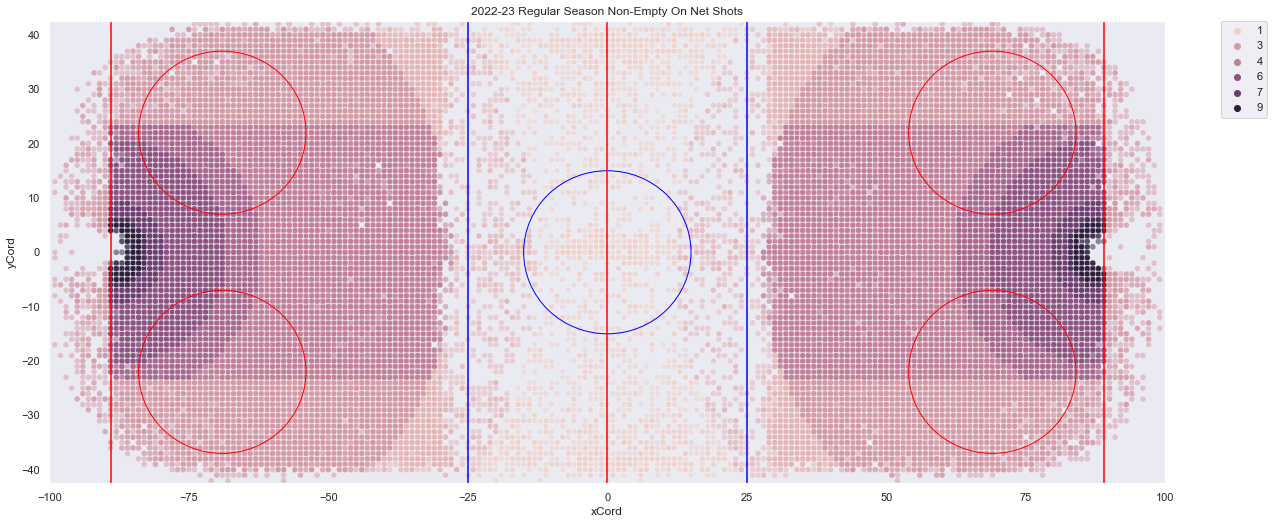

In [5]:
df2 = get_qualities(df)
df_goals=df2[df2['goal']>0]
df_saves=df2[df2['goal']==0]
plot_rink(df_saves, "2022-23 Regular Season Non-Empty On Net Shots")

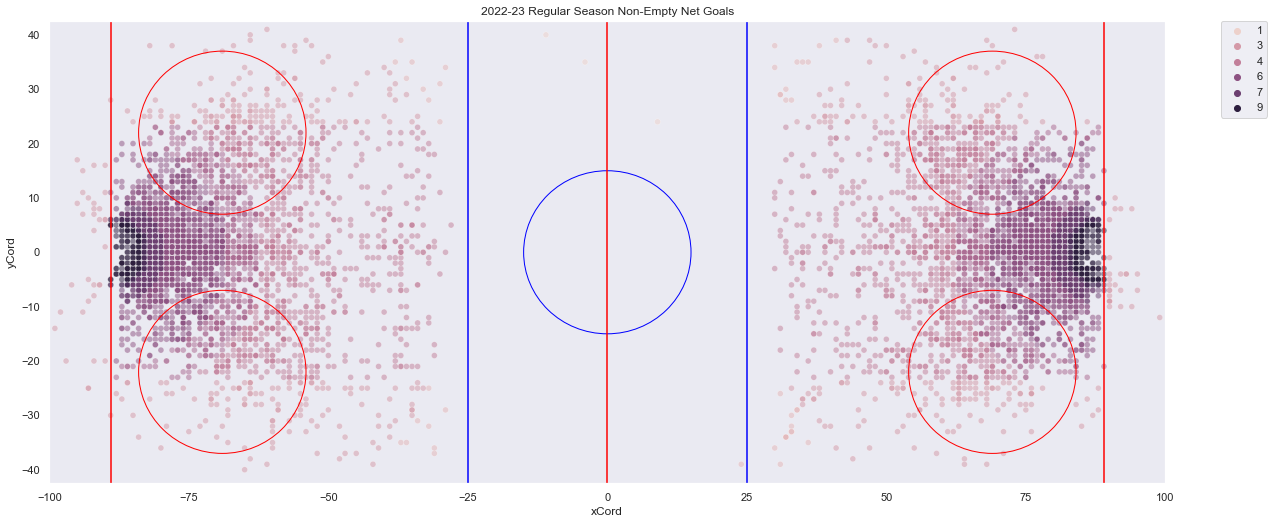

In [6]:
plot_rink(df_goals, "2022-23 Regular Season Non-Empty Net Goals")

In [7]:
#Get percentage of shots that are goals based on the quality
def get_goal_percentage_by_shot_quality(df):
    df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') / df.groupby('quality')['goal']
                                         .transform('count')) * 100)
    return df

In [8]:
#Function from https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

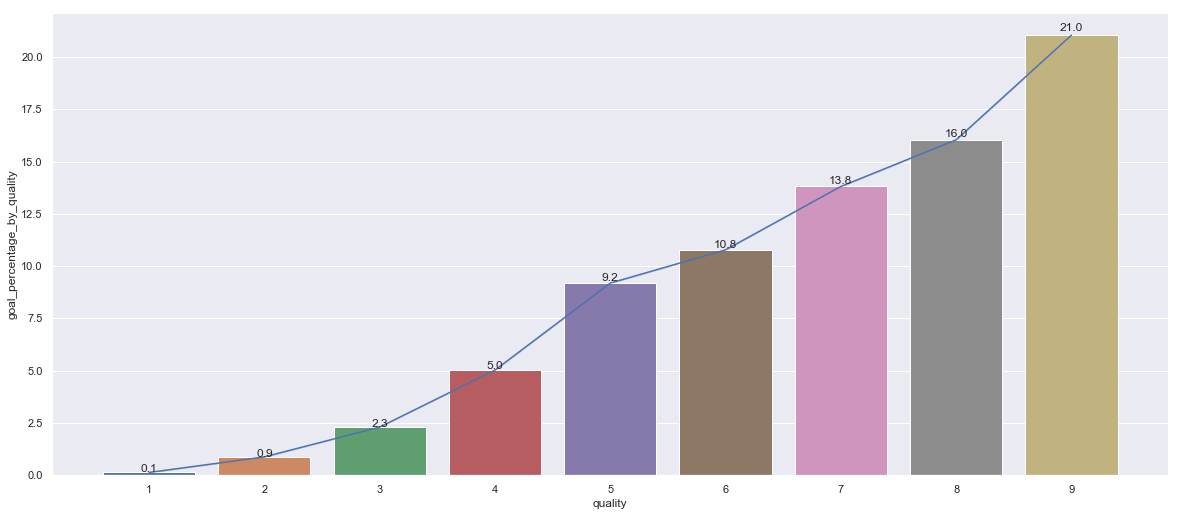

In [9]:
average_quality_save_percentages_df = get_goal_percentage_by_shot_quality(df2)
average_goal_percentage_by_shot_quality = average_quality_save_percentages_df.drop_duplicates('quality').sort_values('quality')
#print(average_quality_save_percentages_df.drop_duplicates('quality').corr()['quality']['goal_percentage_by_quality'])

bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=average_quality_save_percentages_df.drop_duplicates('quality'))
sns.lineplot(x=(average_quality_save_percentages_df['quality']-1), y='goal_percentage_by_quality', 
             data = average_quality_save_percentages_df)

show_values(bar_plot)

In [10]:
def get_goalie_SPAAsq(df, average_df, name, plot):
    # Check each goalie's shots in different qualities to see performance
    df = df[df['goalieNameForShot']==name]
    df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') / 
                                             df.groupby('quality')['goal'].transform('count')) * 100)
    df_qualities = df.drop_duplicates('quality').sort_values('quality')
    
    if plot:
        bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=df.drop_duplicates('quality'))
        sns.lineplot(x=(df['quality']-1), y='goal_percentage_by_quality', data = df)
        sns.lineplot(x=(average_df['quality']-1), y='goal_percentage_by_quality', data = average_df, color='red')
        show_values(bar_plot)
    
    average_goal_percentage_by_shot_quality.rename(columns={'goal_percentage_by_quality': 'average_goal_percentage'}, 
                                                   inplace=True)

    # Merge the DataFrames on the 'quality' column
    merged_df = df_qualities.merge(average_goal_percentage_by_shot_quality, on='quality', how='left')

    # Calculate the difference and create a new column 'SPAAsq'
    merged_df['SPAAsq'] = merged_df['average_goal_percentage'] - merged_df['goal_percentage_by_quality']
    return merged_df['SPAAsq']

<ipython-input-10-f473389783a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /


0    0.133452
1   -0.420613
2    0.307757
3    1.014315
4   -0.388757
5    0.910710
6    1.894071
7    6.040549
8   -8.365253
Name: SPAAsq, dtype: float64

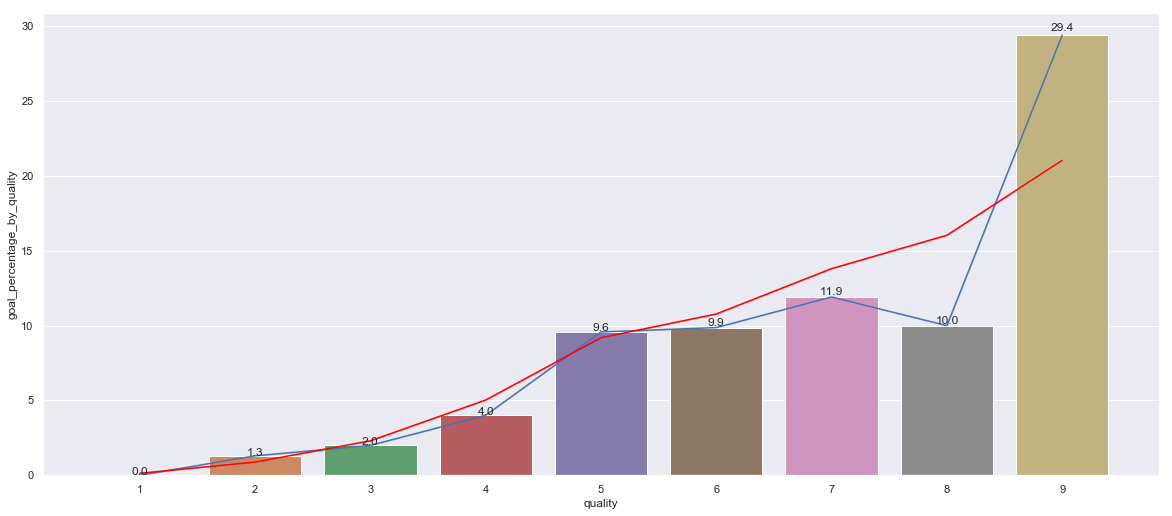

In [11]:
name = 'Andrei Vasilevskiy'
get_goalie_SPAAsq(df, average_quality_save_percentages_df, name, True)

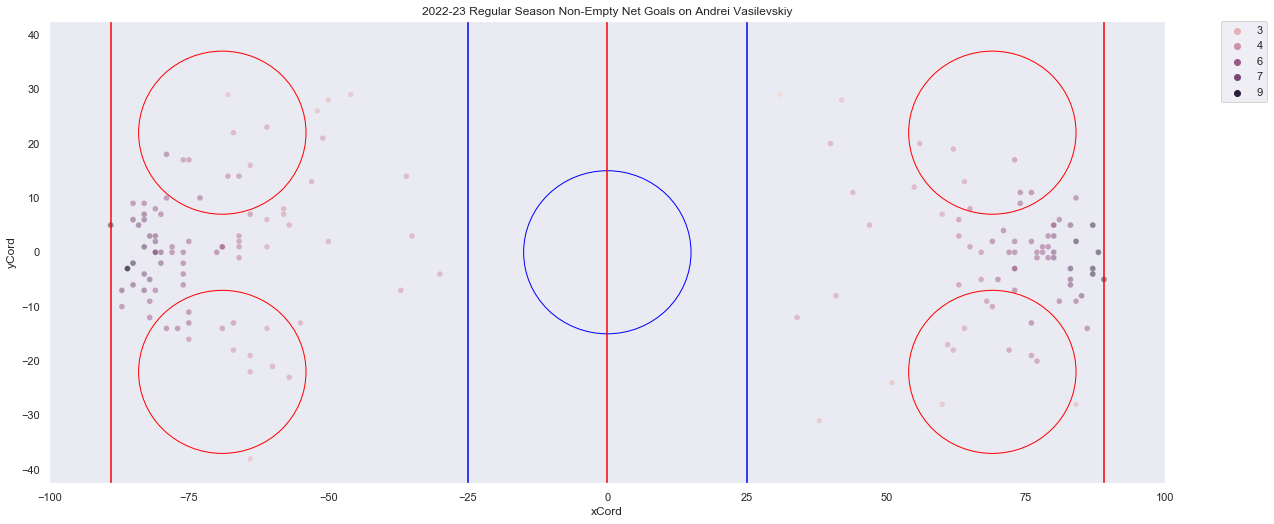

In [12]:
plot_rink(df_goals[df_goals['goalieNameForShot']==name], "2022-23 Regular Season Non-Empty Net Goals on "+name)

In [13]:
#Get SPAAsq for all goalies
def get_all_SPAAsq(df, average):
    goalies = df.drop_duplicates('goalieNameForShot').loc[:, ['goalieNameForShot']]
    goalies.rename(columns={'goalieNameForShot':'Name'}, inplace=True)
    new_columns = goalies['Name'].apply(lambda x: get_goalie_SPAAsq(df, average, x, False))
    new_columns.columns = ['SPAA_Quality1', 'SPAA_Quality2', 'SPAA_Quality3', 'SPAA_Quality4', 'SPAA_Quality5', 
                       'SPAA_Quality6', 'SPAA_Quality7', 'SPAA_Quality8', 'SPAA_Quality9']
    goalies = pd.concat([goalies, new_columns], axis=1)
    goalies.reset_index(drop=True, inplace=True)
    goalies.fillna(0, inplace=True)
    return goalies

In [14]:
def get_all_GSAA(goalies, df):
    # Calculate the count of shots for each goalie by each quality level
    shots_count_by_goalie_quality = df.groupby(['goalieNameForShot', 'quality']).size().unstack(fill_value=0)

    # Iterate through the quality columns and create/update the corresponding GSAA columns in the goalies DataFrame
    for quality in range(1, 10):
        spaa_col_name = f'SPAA_Quality{quality}'
        gsaa_col_name = f'GSAA_Quality{quality}'
        if spaa_col_name in goalies.columns:
            goalies[gsaa_col_name] = round(goalies[spaa_col_name] / 100 * goalies['Name'] 
                                      .map(shots_count_by_goalie_quality[quality]), 4)

    goalies.drop(columns=[f'SPAA_Quality{quality}' for quality in range(1, 10)], inplace=True)

    goalies['GSAA'] = round(goalies.iloc[:, 1:10].sum(axis=1),4)
    goalies = goalies.sort_values('GSAA', ascending = False)
    goalies = goalies[goalies['Name'] != 0]
    return goalies

In [15]:
def get_GSAR_by_names(df, averages, name1, name2):
    goalies = get_all_SPAAsq(df, averages)
    g1 = goalies[goalies['Name']==name1]
    g2 = goalies[goalies['Name']==name2]
    g1.set_index('Name', inplace=True)
    g2.set_index('Name', inplace=True)
    diffs = pd.DataFrame()
    # Perform subtraction for each quality column
    for i in range(1, 10):
        col = f'SPAA_Quality{i}'
        if col in g1.columns and col in g2.columns:
            diff = round(float(g2[col]) - float(g1[col]), 4)
            diffs[f'SPAA_Quality{i}_diff'] = [diff]
            
    #Determine shot qualities amounts given up with Elliot in net vs projected goals with Johansson
    g1_shots = df[df['goalieNameForShot']==name1].loc[:,['shotID','quality']].groupby('quality').count()
    g1_shots.rename(columns={'shotID':'count'},inplace=True)
    
    # Initialize an empty DataFrame with columns
    result_df = pd.DataFrame(columns=['SPAA_Quality1_diff', 'SPAA_Quality2_diff', 'SPAA_Quality3_diff', 'SPAA_Quality4_diff', 'SPAA_Quality5_diff', 'SPAA_Quality6_diff', 'SPAA_Quality7_diff', 'SPAA_Quality8_diff', 'SPAA_Quality9_diff'])

    for i in range(1, 10):  
        col = f'SPAA_Quality{i}_diff'

        if col in diffs.columns:
            diff = float(diffs[col])  # Get the difference value

            # Multiply the difference by the corresponding 'count' value from df_Elliott
            result_df[col] = [diff * float(g1_shots.loc[i, 'count'])]
    # Divide each value in result_df by 100
    result_df = result_df / 100
    total_sum = result_df.sum().sum()
    result_df['GSAR_sq'] = total_sum
    result_df.columns = result_df.columns.str.replace('SPAA', 'GSAR')
    result_df.columns = result_df.columns.str.replace('_diff', '')
    return result_df

<ipython-input-10-f473389783a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /


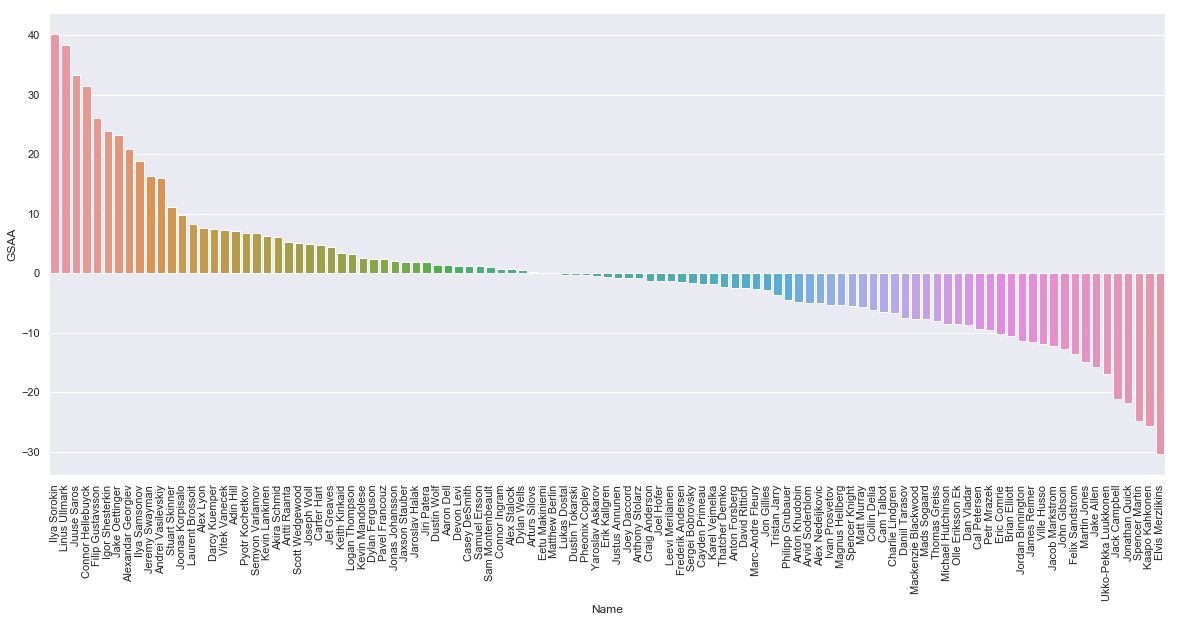

In [16]:
goalies = get_all_GSAA(get_all_SPAAsq(df, average_quality_save_percentages_df), df)
plt.xticks(rotation=90)
sns.barplot(data=goalies, x='Name', y='GSAA')
#Create csv with 2022 GSAA data for all goalies
file_path = 'goalies_GSAAsq.csv'
goalies.to_csv(file_path, index=False)

In [19]:
get_GSAR_by_names(df, average_quality_save_percentages_df, 'Brian Elliott', 'Jonas Johansson')

<ipython-input-10-f473389783a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goal_percentage_by_quality'] = ((df.groupby('quality')['goal'].transform('sum') /


,GSAR_Quality1,GSAR_Quality2,GSAR_Quality3,GSAR_Quality4,GSAR_Quality5,GSAR_Quality6,GSAR_Quality7,GSAR_Quality8,GSAR_Quality9,GSAR_sq
0,0.134028,0.413453,10.557612,-8.473707,11.051592,-21.794373,14.315347,1.40048,-0.156975,7.447457


# Difference in Goals Against for Jonas Johansson on TBL in 2022 Over Brian Elliott Based on Shot Quality Groups
1. 0.134028 (Shots taken from farther than greatest in-zone distance)
2. 0.413453 (Shots taken from 15ft inside greatest in-zone distance)
3. 10.557612 (Shots taken from behind the goal line or outside 48 ft slot area)
4. -8.473707 (Shots taken from between 15ft from farthest point in-zone & 27 feet from net)
5. 11.051592 (Shots taken from 27 to 21 feet from net)
6. -21.794373 (Shots taken from 21 to 9.5 feet from net)
7. 14.315347 (Shots taken from 9.5 to 7 feet from net)
8. 1.40048 (Shots taken from 7 to 6 feet from net)
9. -0.156975 (Shots taken from less than 6 feet from net)

# Conclusions
Based on the analysis, Johansson is a strong replacement over Elliott when facing most all shots (7.5 Goals Saved Above Elliott vs same shots), aside from Quality 4 and Quality 6 shots; therefore, at the league minimum salary, I would suggest Johansson to be an improvement on Elliott. I would also advise that in games where Johansson is the starting goalie, to focus on limiting mid-range (21 to 9.5 ft) shots against.